In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

# Import Data

In [2]:
filename = '108-42.aiff'

# Load in via `librosa`
samples, sr = librosa.load(filename, mono=False)
t_f = len(samples[0]) / sr

In [3]:
import librosa

# VARIABLES
channel = 16
sample = samples[channel - 1]

fmin = 180 # in Hz
fmax = 670

# pYIN algorithm
def find_f0_pyin(sample, fmin=180, fmax=670):
    f0, voiced_flag, voiced_probs = librosa.pyin(sample, fmin=fmin, fmax=fmax)
    return f0, voiced_flag, voiced_probs

f0, _, _ = find_f0_pyin(sample, fmin=fmin, fmax=fmax)


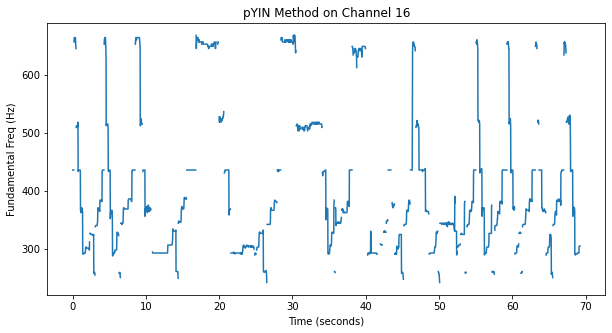

In [4]:
t = np.linspace(0, t_f, len(f0))  # in seconds

plt.figure(figsize=(10,5))

plt.plot(t, f0)
plt.xlabel('Time (seconds)')
plt.ylabel('Fundamental Freq (Hz)')
plt.title(f'pYIN Method on Channel {channel}')
plt.show()

## Clean np.nan values
Nan value becomes the previous value. If there are no previous values, they get dropped.

In [5]:
import numpy as np

def replace_nans(array):
    nan_indices = np.where(np.isnan(array))[0]
    for i in nan_indices:
        if i == 0:
            continue
        array[i] = array[i-1]
    first_non_nan_index = next((i for i, x in np.ndenumerate(array) if not np.isnan(x)), None)
    if first_non_nan_index is not None:
        array = array[first_non_nan_index[0]:]
    return array

In [6]:
f0 = replace_nans(f0)

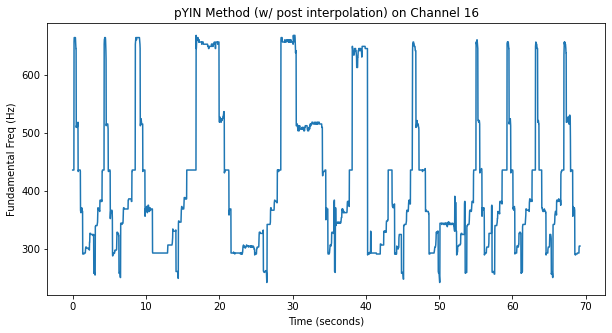

In [7]:
t = np.linspace(0, t_f, len(f0))  # in seconds

plt.figure(figsize=(10,5))

plt.plot(t, f0)
plt.xlabel('Time (seconds)')
plt.ylabel('Fundamental Freq (Hz)')
plt.title(f'pYIN Method (w/ post interpolation) on Channel {channel}')

plt.show()

# Find Period

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

def find_periods(data, height=600, distance=150, show=True):
    """
    Plot the time series data and overlay colored blocks representing the periods between peaks.

    Parameters
    ----------
    data : array-like
        The time series data.
    height : float
        The minimum value that a peak must have to be considered.
    distance : float
        The minimum value that peaks must be horizontally separated by, to be considered.
    """
    # Find the indices of the peaks that are above the threshold
    peak_indices, _ = find_peaks(data, height=height, distance=distance)

    # Compute the differences between consecutive peaks
    periods = np.diff(peak_indices)

    

    # Overlay colored blocks representing the periods
    periods_data = []
    for i in range(len(peak_indices) - 1):
        start = peak_indices[i]
        end = peak_indices[i + 1]
        period = periods[i]
        package = dict(start=start, end=end, period=period)
        periods_data.append(package)
    
    df = pd.DataFrame(periods_data)
        
    if (show == True):
        # Plot the original data
        plt.figure(figsize=(10, 6))
        plt.plot(data, label='Original data')
        
        # Define a list of colors to cycle through
        colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
        
        for i, package in enumerate(periods_data):
            start = package['start']
            end = package['end']
            period = package['period']
            color = colors[i % len(colors)]  # Cycle through the list of colors
            plt.axvspan(start, end, facecolor=color, alpha=0.5, label=f'Period: {period}')
        
        plt.show()
    
    return df

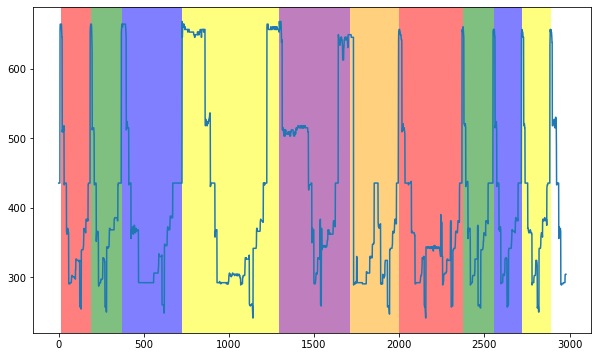

In [9]:
periods_data = find_periods(f0, 600, 150)

In [10]:
periods_data

,start,end,period
0,12,190,178
1,190,372,182
2,372,725,353
3,725,1296,571
4,1296,1708,412
5,1708,2000,292
6,2000,2374,374
7,2374,2557,183
8,2557,2720,163
9,2720,2890,170


# Visualize All Periods Together
First we must analyze all data

0it [00:00, ?it/s]

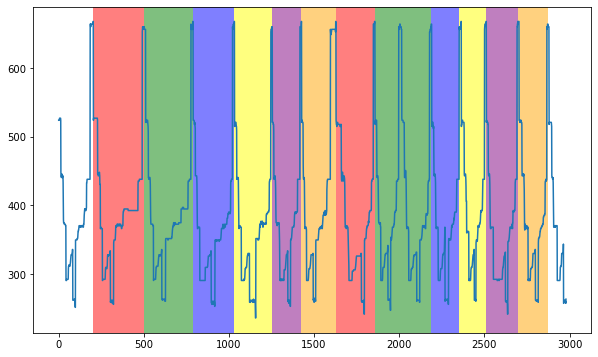

1it [00:01,  1.84s/it]

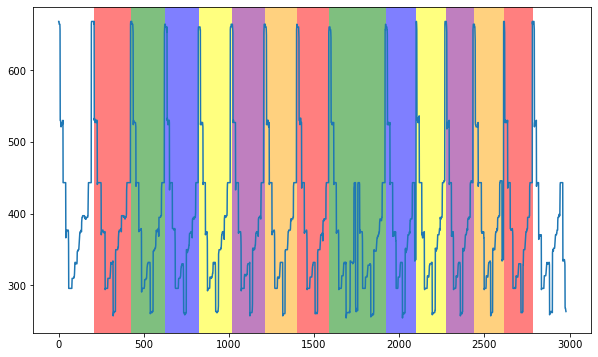

2it [00:03,  1.75s/it]

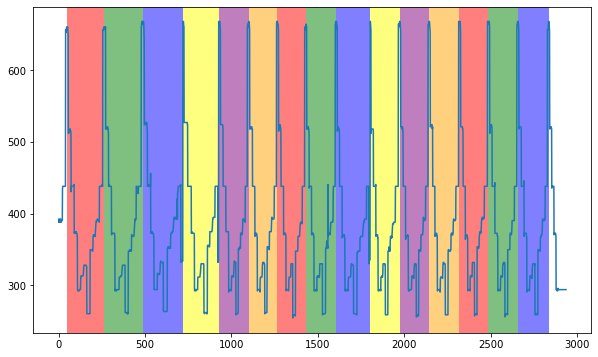

3it [00:05,  1.73s/it]

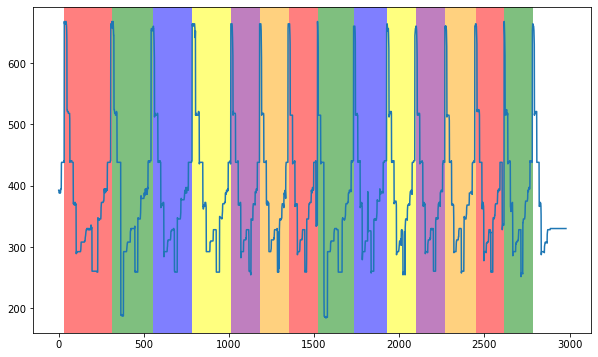

4it [00:06,  1.70s/it]

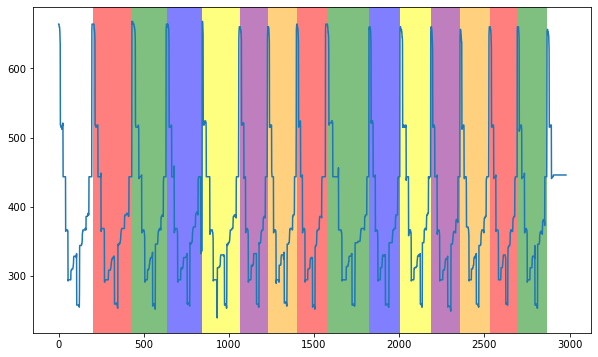

5it [00:08,  1.68s/it]

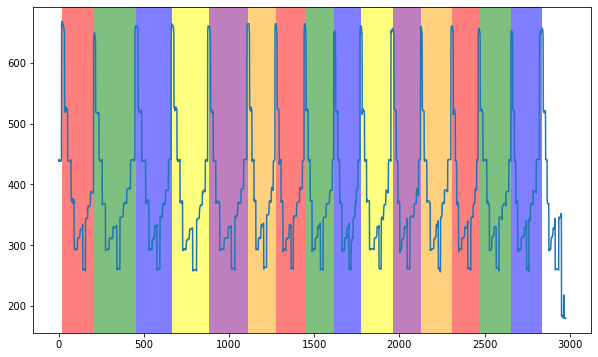

6it [00:10,  1.65s/it]

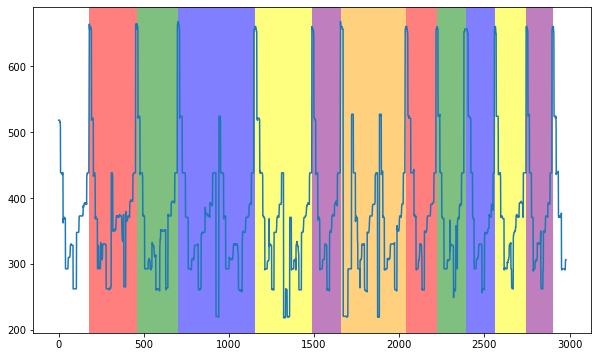

7it [00:11,  1.65s/it]

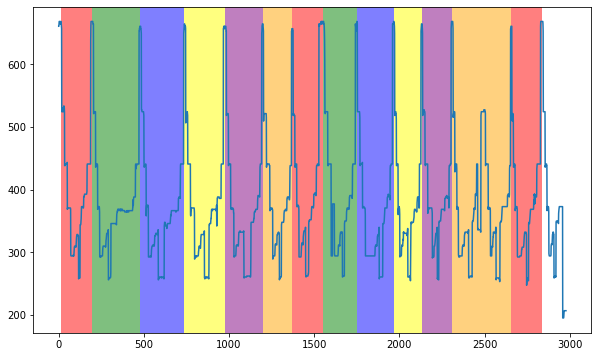

8it [00:13,  1.66s/it]

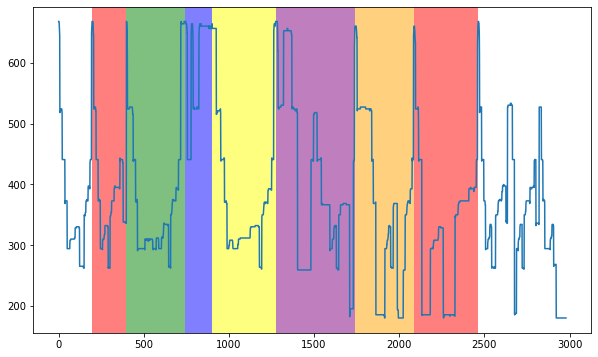

9it [00:15,  1.66s/it]

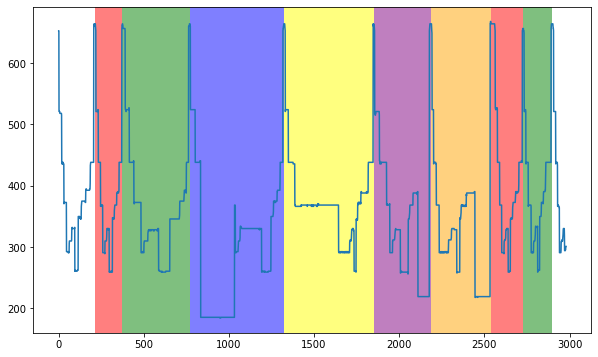

10it [00:16,  1.68s/it]

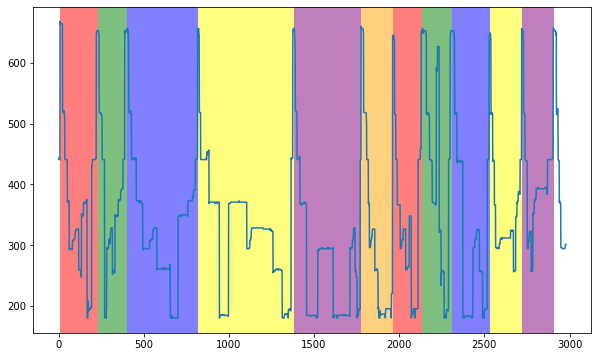

11it [00:18,  1.66s/it]

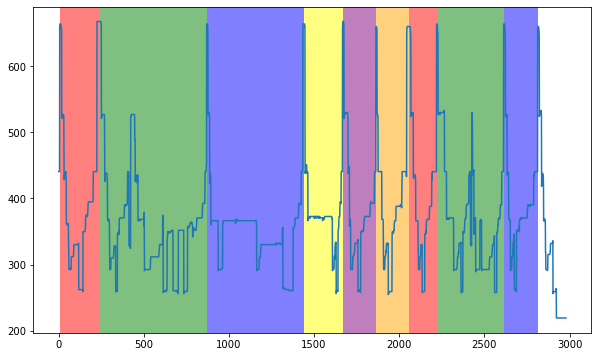

12it [00:20,  1.65s/it]

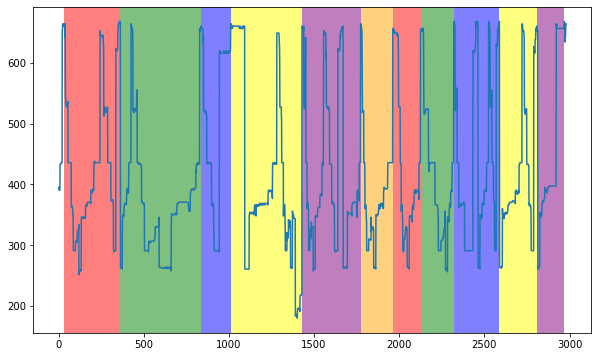

13it [00:21,  1.64s/it]

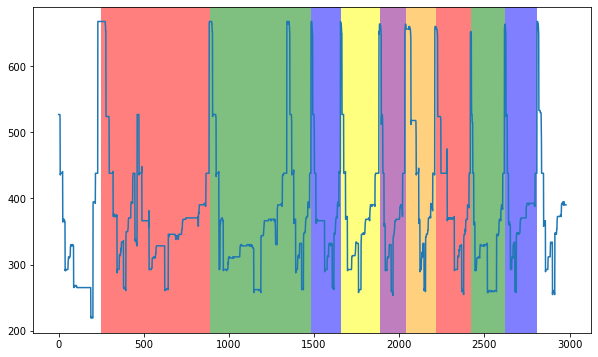

14it [00:23,  1.63s/it]

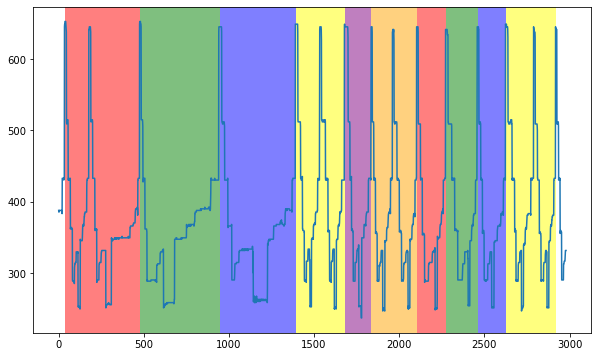

15it [00:25,  1.65s/it]

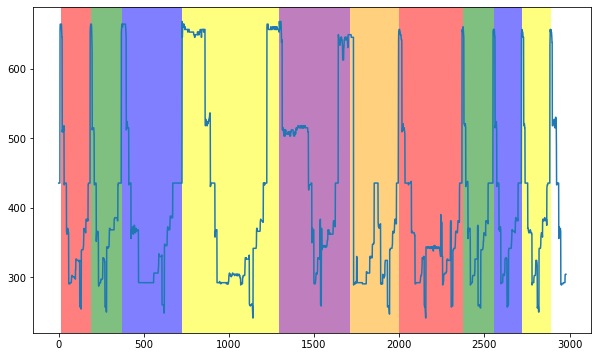

16it [00:26,  1.67s/it]


In [11]:
from tqdm import tqdm

all_periods_data = []
for i, sample in tqdm(enumerate(samples)):
    # Find fundamental frequency
    f0, _, _ = find_f0_pyin(sample)
    
    # Clean f0 data
    f0 = replace_nans(f0)
    
    # Turn it into periods using peak finding method
    # Also visualizes
    periods_data = find_periods(f0)
    
    # Pack in data
    all_periods_data.append(periods_data)

Now we can plot it as a bar chart

16it [00:00, 88.21it/s]


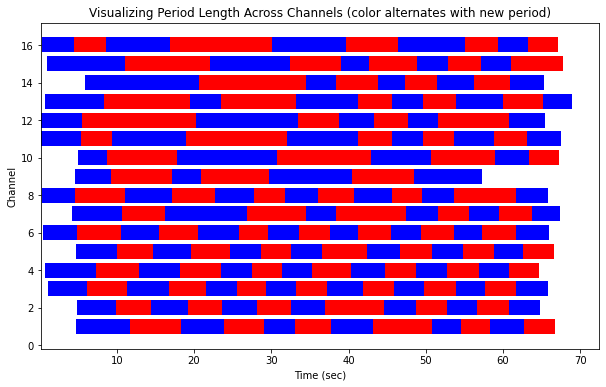

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))

for channel, period_data in tqdm(enumerate(all_periods_data)):
    # Convert from frames to seconds
    t_f = len(samples[0]) / sr
    frame_to_sec = t_f / len(f0)
    
    # Determine bar positions
    start_positions = period_data['start'] * frame_to_sec
    end_positions = period_data['end'] * frame_to_sec
    lengths = [end - start for start, end in zip(start_positions, end_positions)]
    y_positions = np.ones(len(start_positions)) * (channel + 1)
    
    # Labels & coloring
    labels = [str(i+1) for i in y_positions]
    colors = ['blue' if (i%2 == 0) else 'red' for i in range(len(start_positions))]
    
    # Plot bars
    plt.barh(y_positions, lengths, left=start_positions, color=colors)
    

plt.title('Visualizing Period Length Across Channels (color alternates with new period)')
plt.xlabel('Time (sec)')
plt.ylabel('Channel')
plt.savefig('Periods vs Channels.png', dpi=400)
plt.show()

    


# Just realized this period is way too slow... We're having errors in the pYIN method